In [2]:
path = "PRIMNET/FINGER"

from path_handler import get_BASERDIR
import os
BASEDIR, RUNMODE = get_BASERDIR(".")

if BASEDIR.absolute().name == "control":
    os.chdir("..")
os.getcwd()

Running on Jupyter...


'/home/taerim/sOftrobot/PRIMNET-V2/code'

In [3]:
# %%
from pathlib import Path
import sys

try: 
    get_ipython().__class__.__name__
    BASEDIR = Path().absolute()
except: BASEDIR = Path(__file__).parent

sys.path.append(str(BASEDIR))
import torch
from torch import nn
import argparse

import numpy as np
from utils import dataloader
from utils.initalize import INITALZE_EVEN_JOINTS
from utils.update import  update_primnet, update_fc_primnet, update_pcc_primnet


import os
import random
from pathlib import Path
import wandb
import time
import json

from utils.tools import set_seed, set_wandb, print_log_dict, prefix_dict, average_dict
from utils.path_handler import JUPYTER, RUN, DEBUG, get_BASERDIR
from utils.args import read_ARGS
from utils.logger import CSVLogger,ask_and_make_folder
from utils.tools import cast_numpy

from configs.template import PRIMNET_ARGS_TEMPLATE, FC_PRIMNET_ARGS_TEMPLATE, PCC_PRIMNET_ARGS_TEMPLATE
from model.PRIMNET import PRIMNET
from model.FC_PRIMNET import FC_PRIMNET
from typing import Union

from utils.dataloader import get_dataset, Sampler

In [4]:
BASEDIR, RUNMODE = get_BASERDIR(os.getcwd())
args = read_ARGS((BASEDIR/'results'/path/"args.py").absolute())
args

Running on Jupyter...


ARGS(MODEL='PRIMNET', EVEN_JOINTS=True, WANDB=True, pname='PRIMNET_v2.2', runname='FINGER', DATASET='FINGER', TPOSE=((0, 0, 0.12),), LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, EVEN_JOINT=True, p_offset_std=0.1, rpy_offset_std=0.01, axis_std=0.1, OUTPUT_NORMALIZE=False, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, w_vec=0.005, epochs=2000, focus_ratio=0.0, data_ratio=1.0, n_workers=2, batch_size=64, joint_seqs=('F', 'R', 'P', 'R', 'R', 'P', 'R'), marker_num=1, motor_dim=2)

In [71]:
if args.MODEL == 'PRIMNET':
    model = PRIMNET(args=args).to(args.device)
elif args.MODEL == 'FC_PRIMNET':
    model = FC_PRIMNET(args=args).to(args.device)

model.load_state_dict(torch.load(BASEDIR/'results'/path/"weights/epoch_200.pth"))

<All keys matched successfully>

In [72]:
def forward_motor(model:PRIMNET, motor_control):     
    motor_control = model.normalize(motor_control)
    
    # Forward
    act_embeds = model.ACT_EMBED.layers(motor_control)
    q_values = model.FK_LAYER.forward_q(act_embeds)
    joint_se3 = model.FK_LAYER.forward_kinematics(q_values)
    
    return model.t2p(joint_se3, OUTPUT_NORMALIZE=False)



## Forward Kinematics

In [73]:
train_dataset,val_dataset,test_dataset,ext_dataset  = get_dataset(f"../dataset/FINGER.json", args.data_ratio)



In [74]:
model.motor_mean, model.motor_std, model.position_mean, model.position_std

(tensor([  0.7379, -50.0518]),
 tensor([557.4562, 569.9876]),
 tensor([[0.],
         [0.],
         [0.]]),
 tensor([[1.],
         [1.],
         [1.]]))

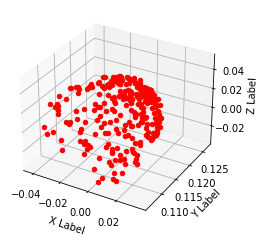

In [102]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for pos in train_dataset.position:
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0], pos_[1], pos_[2], c='r')
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

In [79]:
rest_pos = model(torch.zeros(1,2).to(torch.float))[0,-1].detach().numpy()

In [89]:
ps[0]

array([ 0.1005518 ,  0.23372969, -0.09769266], dtype=float32)

In [91]:
target_position

tensor([-0.0205,  0.1127, -0.0195])

tensor([[ -7.7121, -29.0906]])
tensor([-0.0045,  0.1263,  0.0005])


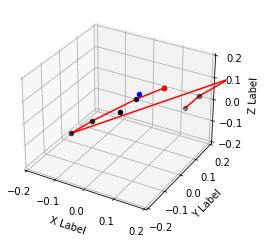

tensor([[-108.4033,  193.8312]])
tensor([-0.0029,  0.1255,  0.0102])


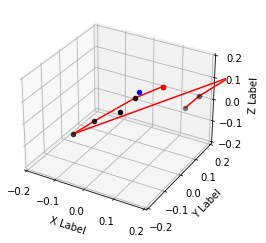

tensor([[1035.5627, -308.2518]])
tensor([-0.0351,  0.1129, -0.0061])


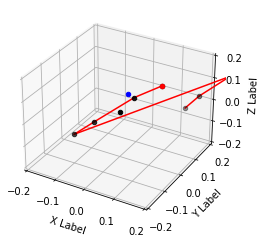

tensor([[ 136.6546, -123.0855]])
tensor([-0.0116,  0.1246, -0.0029])


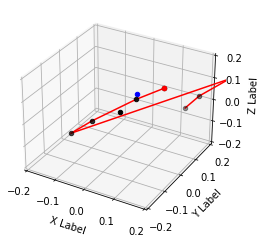

tensor([[-179.2570, 1159.7443]])
tensor([-0.0040,  0.1131,  0.0455])


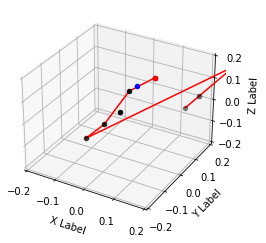

tensor([[ 625.9771, -413.3505]])
tensor([-0.0212,  0.1182, -0.0089])


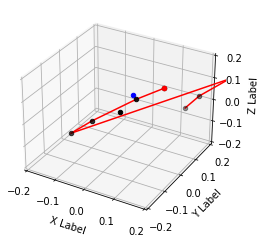

tensor([[755.3502, -72.1851]])
tensor([-0.0275,  0.1193, -0.0005])


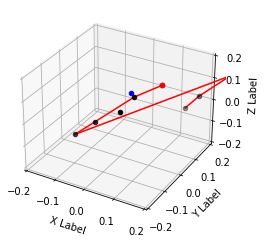

tensor([[-242.3749, -389.5875]])
tensor([ 0.0026,  0.1213, -0.0094])


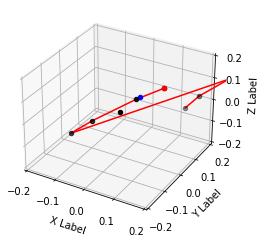

tensor([[-141.6924,  326.8397]])
tensor([-0.0049,  0.1244,  0.0172])


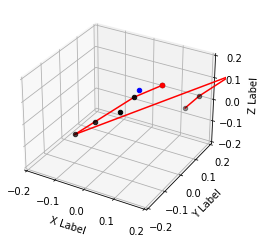

tensor([[ 673.6536, -759.9678]])
tensor([-0.0205,  0.1127, -0.0195])


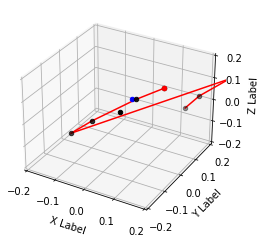

In [100]:
from matplotlib import pyplot as plt


for idx in range(0,10):

    motor_control = train_dataset.motor_control[idx][None,:]
    print(motor_control)
    target_position = train_dataset.position[idx].flatten()
    print(target_position)

    ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()
    # ps[-1,:], target_position

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(0,0,0,color='k')
    i = 0
    for p in ps:
        i = i +1
        ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1 + 0.3)
    
    ax.scatter(p[0], p[1],p[2], color = 'r', alpha = 1)

    for p_fr, p_to in zip(ps[:-1], ps[1:]):
        ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

    ax.scatter(target_position[0], target_position[1], target_position[2], color='b')

    ax.set_xlim(-0.20, 0.20)
    ax.set_ylim(-0.20, 0.20)
    ax.set_zlim(-0.20, 0.20)
    
    # name x,y,z label to ax
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    
    # ax.view_init(elev=0, azim=0)

    plt.show()




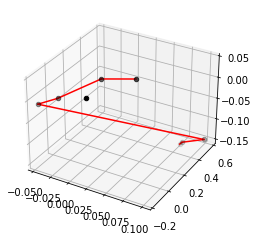

array([0.04817899, 0.1650061 , 0.04005003], dtype=float32)

In [99]:
motor_control = torch.FloatTensor([1000,0]).unsqueeze(0)
ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(0,0,0,color='k')

i = 0
for p in ps:
    i = i +1
    ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1)

for p_fr, p_to in zip(ps[:-1], ps[1:]):
    ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.2, 0.2)
# ax.set_zlim(-0.2, 0.2)
plt.show()

# print(ps[-1,:,0])
ps[-1]

In [19]:
p

array([[8.8453293e-05],
       [9.0118051e-03],
       [1.2641597e-01]], dtype=float32)

In [20]:
ps

array([[[-1.9070978e+00],
        [ 1.7842922e+00],
        [-1.3818427e+00]],

       [[-2.0818133e+00],
        [-4.2184770e-01],
        [-3.5543365e+00]],

       [[-2.0622771e+00],
        [-4.0978503e-01],
        [-3.3979957e+00]],

       [[-1.9421979e+00],
        [-6.6769642e-01],
        [-1.6843398e+00]],

       [[-1.9440267e+00],
        [-6.5659124e-01],
        [-1.5001571e+00]],

       [[-1.9501210e+00],
        [-6.6574293e-01],
        [-1.3057662e+00]],

       [[ 8.8453293e-05],
        [ 9.0118051e-03],
        [ 1.2641597e-01]]], dtype=float32)